In [1]:
!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

/bin/bash: line 1: conda: command not found


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from PIL import Image

In [3]:
print(torch.__version__)

2.8.0+cu126


In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
EPOCHS = 10
STEP = 10
LR = 0.1
GAMMA = 0.1
IMG_SIZE = 128
BATCH = 32
# OUT_SIZE = len(le.classes_)

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
class Pipeline(Dataset):
    def __init__(self, data, transform=None):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [9]:
from pathlib import Path

def create_df(path):
    dd = {"images": [], "labels": []}
    for label_name in os.listdir(path):
        img_dir = os.path.join(path, label_name)
        if not os.path.isdir(img_dir):
            continue  # skip non-directories (e.g., hidden files)
        for img_file in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img_file)
            if os.path.isdir(img_path):
                continue
            dd["images"].append(img_path)
            dd["labels"].append(label_name)
    return pd.DataFrame(dd)


base_dir = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10")
train_dir = base_dir / "train"
val_dir = base_dir / "val"

train_df = create_df(train_dir)
val_df = create_df(val_dir)

train_ds = Pipeline(train_df, transform)
val_ds = Pipeline(val_df, transform)

In [10]:
import pandas as pd
import numpy as np

TARGET_SIZE = 4500
current_size = len(train_df)
excess = current_size - TARGET_SIZE

print("Excess images to remove:", excess)

# Randomly sample the rows to DROP
drop_df = train_df.sample(excess, random_state=42)

# Create a reduced dataframe
train_df_reduced = train_df.drop(drop_df.index).reset_index(drop=True)

print("New training size:", len(train_df_reduced))

Excess images to remove: 67
New training size: 4500


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["labels"] = le.fit_transform(train_df["labels"])
val_df["labels"] = le.transform(val_df["labels"])

In [12]:
def create_df(path):
    path = Path(path)
    images = []
    labels = []
    valid_exts = {".jpg", ".jpeg", ".png", ".bmp"}

    # Traverse each class folder (e.g., basophil, seg_neutrophil, etc.)
    for label_dir in path.iterdir():
        if not label_dir.is_dir():
            continue  # skip non-folder items

        # Collect image files inside each class folder
        for img_path in label_dir.glob("*"):
            if img_path.is_file() and img_path.suffix.lower() in valid_exts:
                images.append(str(img_path))
                labels.append(label_dir.name)
            else:
                # Skip subdirectories or non-image files
                continue

    df = pd.DataFrame({"images": images, "labels": labels})
    print(f" Created dataframe from {path}")
    print(f"   Total image files found: {len(df)}")
    return df

In [16]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/val"

# 1. Load train/val once
train_df = create_df(train_dir)
val_df = create_df(val_dir)

# 2. Reduce train_df to 4500 (do NOT reload afterwards)
import pandas as pd

TARGET_SIZE = 4500
current_size = len(train_df)
excess = current_size - TARGET_SIZE

print("Current train size:", current_size)
print("Removing:", excess)

drop_df = train_df.sample(excess, random_state=42)
train_df = train_df.drop(drop_df.index).reset_index(drop=True)

print("New train size:", len(train_df))

# 3. Now encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["labels"] = le.fit_transform(train_df["labels"])
val_df["labels"] = le.transform(val_df["labels"])

 Created dataframe from /content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/train
   Total image files found: 4567
 Created dataframe from /content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/val
   Total image files found: 500
Current train size: 4567
Removing: 67
New train size: 4500


In [17]:
# Create dataset pipelines (if you’re using transforms)
train_ds = Pipeline(train_df, transform)
val_ds = Pipeline(val_df, transform)

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["labels"] = le.fit_transform(train_df["labels"])
val_df["labels"] = le.transform(val_df["labels"])

OUT_SIZE = len(le.classes_)
print("Number of classes (OUT_SIZE):", OUT_SIZE)

Number of classes (OUT_SIZE): 5


In [19]:
from torchvision.models import resnet18, ResNet18_Weights

# Use pretrained weights if allowed (better accuracy with fewer epochs)
# model_base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

model_base = resnet18(weights=None)

num_ftrs = model_base.fc.in_features
model_base.fc = nn.Linear(num_ftrs, OUT_SIZE)

class ResNet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet(model_base).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [20]:
# best_model = deepcopy(model)
# best_model = deepcopy(model.cpu()).to(device)
best_model = model
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [21]:
print(len(train_dl))
print(len(val_dl))
print(train_dl.batch_size)

141
16
32


In [22]:
print(f"Dataset size: {len(train_dl.dataset)}")
print(type(train_dl.dataset))

Dataset size: 4500
<class '__main__.Pipeline'>


In [23]:
def train_one_epoch(model, train_dl, optimizer, criterion, device):
    model.train()
    diff = 0
    acc = 0
    total = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if device == "cuda":
            data, target = data.cuda(), target.cuda()
        # print(data.shape, target.shape)

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)

        loss.backward()
        optimizer.step()

    return diff / total, acc / total

In [24]:
def validate(model, val_dl, criterion, device):
    model.eval()
    diff = 0
    acc = 0
    total = 0

    with torch.no_grad():
        for data, target in val_dl:
            if device == "cuda":
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    return diff / total, acc / total

In [25]:
dir_count = sum(os.path.isdir(p) for p in train_df["images"])
print(f"There are {dir_count} directory paths in train_df out of {len(train_df)} rows.")

There are 0 directory paths in train_df out of 4500 rows.


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# device = "cpu"
# if device == "cuda":
#     model = model.cuda()

for i in range(1, EPOCHS + 1):
    train_loss_epoch, train_acc_epoch = train_one_epoch(model, train_dl, optimizer, criterion, device)
    val_loss_epoch, val_acc_epoch = validate(model, val_dl, criterion, device)

    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

    if val_acc_epoch >= best_acc:
        best_acc = val_acc_epoch
        best_state_dict = deepcopy(model.state_dict())
        best_model = deepcopy(model)
        best_model.load_state_dict(best_state_dict)
        best_model.to(device)
        best_model.eval()

    scheduler.step()

    print(f"Epoch {i} train loss {train_loss_epoch:.4f} acc {train_acc_epoch:.4f} val loss {val_loss_epoch:.4f} acc {val_acc_epoch:.4f}")

Epoch 1 train loss 0.0282 acc 0.7956 val loss 0.0075 acc 0.9020
Epoch 2 train loss 0.0063 acc 0.9353 val loss 0.0025 acc 0.9760
Epoch 3 train loss 0.0036 acc 0.9613 val loss 0.0074 acc 0.9080
Epoch 4 train loss 0.0027 acc 0.9744 val loss 0.0066 acc 0.9360
Epoch 5 train loss 0.0017 acc 0.9838 val loss 0.0093 acc 0.8840
Epoch 6 train loss 0.0018 acc 0.9822 val loss 0.0011 acc 0.9840
Epoch 7 train loss 0.0015 acc 0.9840 val loss 0.0034 acc 0.9580
Epoch 8 train loss 0.0011 acc 0.9902 val loss 0.1088 acc 0.5580
Epoch 9 train loss 0.0011 acc 0.9882 val loss 0.0016 acc 0.9840
Epoch 10 train loss 0.0005 acc 0.9951 val loss 0.0005 acc 0.9960


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, classification_report

In [28]:
from copy import deepcopy
import torch

if val_acc[-1] >= best_acc:
    best_acc = val_acc[-1]
    best_model = deepcopy(model)

    torch.save(best_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/blood_cell_models/best_model.pth")
    print(f"Best model saved at epoch {i} with val acc {best_acc:.4f}")

Best model saved at epoch 10 with val acc 0.9960


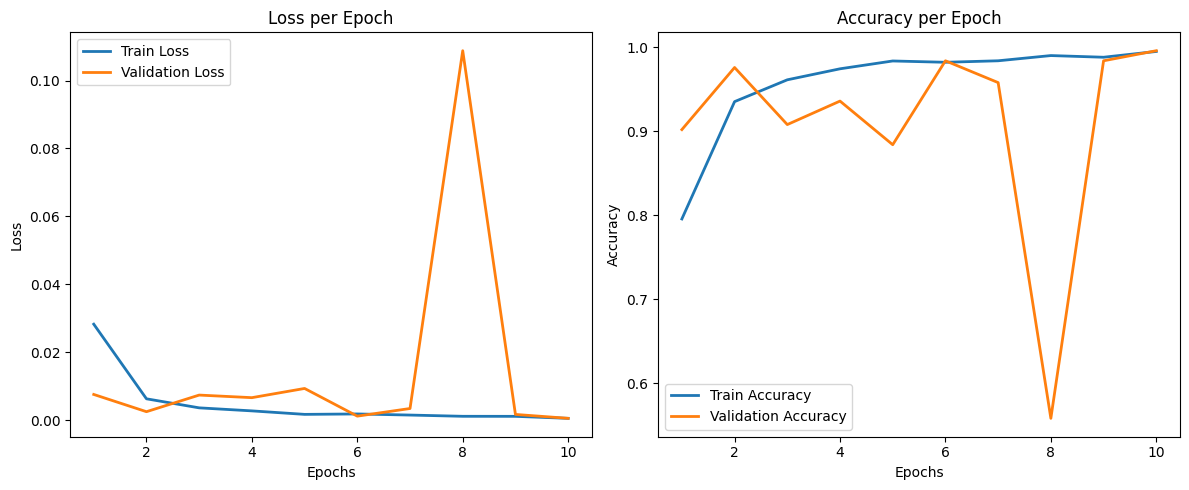

In [29]:
# 1. PLOT TRAINING AND VALIDATION LOSS & ACCURACY
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", linewidth=2)
plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(False)  # Disable background grid

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy", linewidth=2)
plt.plot(epochs, val_acc, label="Validation Accuracy", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(False)  # Disable background grid

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
from torchvision import datasets, transforms

Classes in dataset: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

Classification Report (from confusion matrix):
Class               Precision     Recall   F1-Score  Support
basophil                1.000      0.010      0.020      100
erythroblast            0.467      0.910      0.617      100
monocyte                0.840      0.890      0.864      100
myeloblast              0.926      1.000      0.962      100
seg_neutrophil          1.000      0.900      0.947      100

Accuracy                0.742                            500
Macro Avg               0.846      0.742      0.682      500
Weighted Avg            0.846      0.742      0.682      500


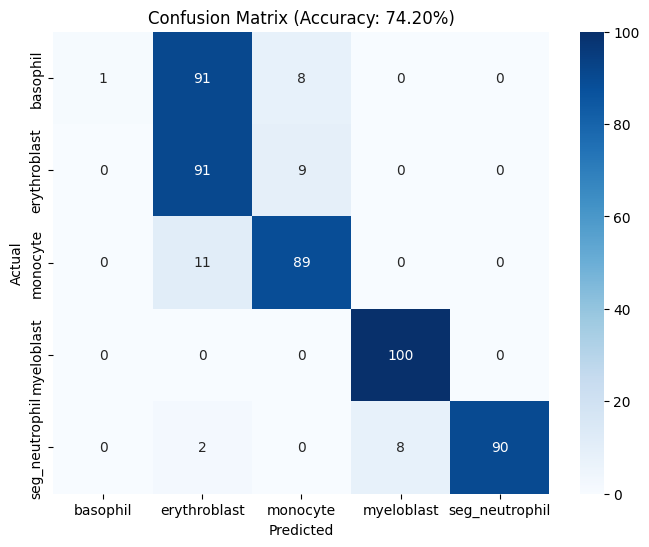

In [31]:
# FULL EVALUATION PROGRAM

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Paths & Device
base_dir = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10")
val_dir = base_dir / "val"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Transform (must match training!)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load Validation Dataset
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

print("Classes in dataset:", val_dataset.classes)
class_names = val_dataset.classes

# Load Best Model
# Replace with your model definition
# Example: model = MyModel(num_classes=len(class_names))
# model.load_state_dict(torch.load("/path/to/best_model.pth"))
# model.to(device)
# model.eval()

# For illustration, assuming `best_model` is already loaded
best_model.to(device)
best_model.eval()

# Prediction Function
def predict(img_tensor):
    img_tensor = img_tensor.view(1, 3, 224, 224).to(device)
    with torch.no_grad():
        out = best_model(img_tensor)
        probs = F.softmax(out, dim=1)
    index = probs.argmax(1).item()
    return index, probs[0][index].item()

# Make Predictions
truth, preds, probas = [], [], []

for img, label in val_loader:
    pred, proba = predict(img)
    preds.append(pred)
    truth.append(label.item())
    probas.append(proba)

# Compute Confusion Matrix
cm_int = confusion_matrix(truth, preds)
cm = cm_int.astype(int)

# Optional: Filter unwanted classes
exclude_labels = [".DS_Store", "class_5", "class_6"]  # adjust as needed
filtered_names = [name for name in class_names if name not in exclude_labels]
keep_indices = [i for i, name in enumerate(class_names) if name not in exclude_labels]
cm_filtered = cm[np.ix_(keep_indices, keep_indices)]

# Compute Metrics manually
num_classes = len(filtered_names)
precision, recall, f1 = [], [], []
support = cm_filtered.sum(axis=1)

for i in range(num_classes):
    tp = cm_filtered[i, i]
    fp = cm_filtered[:, i].sum() - tp
    fn = cm_filtered[i, :].sum() - tp

    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0

    precision.append(prec)
    recall.append(rec)
    f1.append(f1_score)

# Accuracy
accuracy = cm_filtered.trace() / cm_filtered.sum()

# Macro average
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

# Weighted average
weighted_precision = np.sum(np.array(precision) * support) / support.sum()
weighted_recall = np.sum(np.array(recall) * support) / support.sum()
weighted_f1 = np.sum(np.array(f1) * support) / support.sum()

# Print Classification Report
print("\nClassification Report (from confusion matrix):")
print(f"{'Class':<18} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>8}")
for i, name in enumerate(filtered_names):
    print(f"{name:<18} {precision[i]:>10.3f} {recall[i]:>10.3f} {f1[i]:>10.3f} {support[i]:>8}")

print(f"\n{'Accuracy':<18} {accuracy:>10.3f} {'':>10} {'':>10} {support.sum():>8}")
print(f"{'Macro Avg':<18} {macro_precision:>10.3f} {macro_recall:>10.3f} {macro_f1:>10.3f} {support.sum():>8}")
print(f"{'Weighted Avg':<18} {weighted_precision:>10.3f} {weighted_recall:>10.3f} {weighted_f1:>10.3f} {support.sum():>8}")

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_names, yticklabels=filtered_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Accuracy: {accuracy*100:.2f}%)')
plt.show()

In [35]:
print(cm_filtered)

[[  1  91   8   0   0]
 [  0  91   9   0   0]
 [  0  11  89   0   0]
 [  0   0   0 100   0]
 [  0   2   0   8  90]]


In [32]:
global_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)

print(f"\nOverall Weighted Metrics:\n"
      f"{'Accuracy':<18}: {accuracy:.3f}\n"
      f"{'Weighted Precision':<18}: {weighted_precision:.3f}\n"
      f"{'Weighted Recall':<18}: {weighted_recall:.3f}\n"
      f"{'Global F1':<18}: {global_f1:.3f}\n"
      f"{'Weighted F1-score':<18}: {weighted_f1:.3f}")


Overall Weighted Metrics:
Accuracy          : 0.742
Weighted Precision: 0.846
Weighted Recall   : 0.742
Global F1         : 0.791
Weighted F1-score : 0.682


In [33]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import datasets, transforms
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

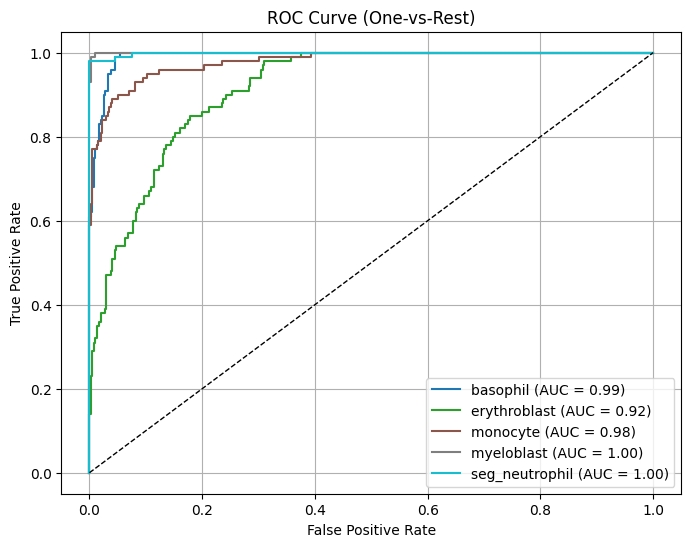

In [34]:
# 1. Collect probabilities and labels correctly
best_model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for img, labels in val_loader:
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)

        # softmax over classes
        probs = torch.nn.functional.softmax(out, dim=1).cpu().numpy()

        # store all samples in batch, not just probs[0]
        all_probs.append(probs)
        all_labels.append(labels.numpy())

# concatenate into full arrays
all_probs = np.vstack(all_probs)      # shape: [N, n_classes]
all_labels = np.concatenate(all_labels)  # shape: [N]

# 2. Binarize labels for ROC
n_classes = len(val_dataset.classes)
truth_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# 3. Compute ROC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(truth_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot ROC curves
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap("tab10", n_classes)

for i, class_name in enumerate(val_dataset.classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_name} (AUC = {roc_auc[i]:.2f})",
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()